In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
import numpy as np
import lovely_tensors as lt
from PIL import Image
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.utils.preproc_utils import get_info_from_vistorybench, get_panel_layout, get_all_kwargs_from_opens2v_metapath
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img

sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
# sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
vistory_dataset_path = Path("/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Device set to use cuda:0


## Load Model

In [2]:
framepack_model = FramePack_1fmc(
    lora_path = "../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_5-step00006000.safetensors"
)

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False


INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_5-step00006000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyu

Model, VAE, Text Encoders, LoRA loaded.


### Single Panel Generation : Custom Input

In [ ]:
prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
height, width = 960, 960
panel_layout = {0 : {'bbox': [ 0.6, 0.1, 1.0, 1.0 ], 'body': []}}
characters_shot = {0 : {'images' : ["../../docs/fg_sample.jpg"]} }
seed = 42

result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt=prompt,
    panel_layout=panel_layout,
    characters_shot=characters_shot,
    width=width, height=height, seed=seed, c_width_given=320
)
debug_imgs[0]

### Single Panel Generation : From Cache

In [ ]:
width, height = 1280, 720
seed = 2048
total_kwargs, total_nps = get_all_kwargs_from_opens2v_metapath(
    Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets/test3_2/zYwOTomP5EE_segment_59_step1-12-125_step2-12-113_step4_step5_step6"),
    seed=seed, width=width, height=height, 
)
prompt = total_kwargs['prompt']
panel_layout = {i : {'bbox': x, 'body': []} for i,x in enumerate(total_nps['bboxes'])}
characters_shot = {i : {'images' : [x]} for i,x in enumerate(total_kwargs['control_image_paths'])}

result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt=prompt,
    panel_layout=panel_layout,
    characters_shot=characters_shot,
    width=width, height=height, seed=seed, c_width_given=None,
)
debug_imgs[0]

### Single Panel Generation : ViStoryBench

In [ ]:
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, '04', 1)
prompt = story_shot['type'] + ";" + prompt
width, height = 1280, 720
seed = 42
panel_layout = {
    1: {'bbox': [0.1, 0.25, 0.45, 0.95], 'body': []},
    0: {'bbox': [0.6, 0.1, 0.95, 0.95], 'body': []},
}

result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt=prompt,
    panel_layout=panel_layout,
    characters_shot=characters_shot,
    width=width, height=height, seed=seed, c_width_given=320
)
debug_imgs[0]

## Comic Generation : ViStoryBench (no comic layout)

In [ ]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
timestamp = '20251016_150910'
out_dir = Path("../../outputs/whisperer") / f"debug/en/{timestamp}"
out_dir.mkdir(parents=True, exist_ok=True)

main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053")
story_num = '16'
seed = 48
(out_dir / story_num).mkdir(parents=True, exist_ok=True)
(out_dir / f"{story_num}/debug").mkdir(parents=True, exist_ok=True)
(out_dir / f"{story_num}/full").mkdir(parents=True, exist_ok=True)

main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20251004_200710_v2")
pose_layout = json.loads((main_layout_path / f"story_{story_num}/pose_layout.json").read_text())

for shot_num, layout in pose_layout.items():
    shot_num = int(shot_num)
    # width, height = layout['canvas_size']['w'], layout['canvas_size']['h']
    width, height = 1344, 768
    panel_layout = {row['id']-1 : {
        'bbox' : list(map(lambda x: x/1000., [row['bbox']['x'], row['bbox']['y'], row['bbox']['x']+row['bbox']['w'], row['bbox']['y']+row['bbox']['h']])), 
        'body': []
    } for row in layout['boxes']}

    story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
    prompt = story_shot['type'] + ";" + prompt
    print(f"\n=== Story {story_num} - Shot {shot_num} ===")
    print(f"Prompt: {prompt}")

    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=320, seed=seed, 
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    result_imgs[0].save(out_dir / story_num / f"{shot_num-1}_0.png")
    debug_imgs[0].save(out_dir / story_num / f"debug/{shot_num-1}_0.png")

shutil.copy(
    "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/test_seg_4.ipynb", 
    out_dir / f"{story_num}/full/test_seg_4.ipynb"
)

## Comic Generation : ViStoryBench (comic layout)

In [ ]:
main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053")
story_num = '02'
seed = 48
# layouts = sorted(list(main_layout_path.glob(f"story_{story_num}*")))
start_shot_num, end_shot_num = 1, 6
author_output_dir = main_layout_path / f"story_{story_num}-pages_{start_shot_num}_{end_shot_num}"

config_layout = json.loads((author_output_dir / "config.json").read_text())
joint_layout = json.loads((author_output_dir / "pose_layout.json").read_text())
page_w, page_h = config_layout['page_size']

In [13]:
panel_id = '[PANEL-2]'
layout = joint_layout[panel_id]

shot_num = min(start_shot_num + int(panel_id.replace('[PANEL-', '').replace(']', ''))-1, end_shot_num)
panel_layout, width, height = get_panel_layout(layout, page_w, page_h)
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = story_shot['type'] + ";" + prompt
characters_shot

{'David': {'name': 'David',
  'key': 'David',
  'prompt': 'A lively Caucasian boy with blond hair and blue eyes, about five or six years old, always wearing a mischievous smile. He is dressed in a simple T-shirt and shorts, often wearing small sneakers, sometimes covered in mud or water stains, looking a bit messy but full of energy.',
  'tag': 'unrealistic_human',
  'num_of_appearances': 9,
  'images': ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/02/image/David/00.jpg']}}

  0%|          | 0/25 [00:00<?, ?it/s]

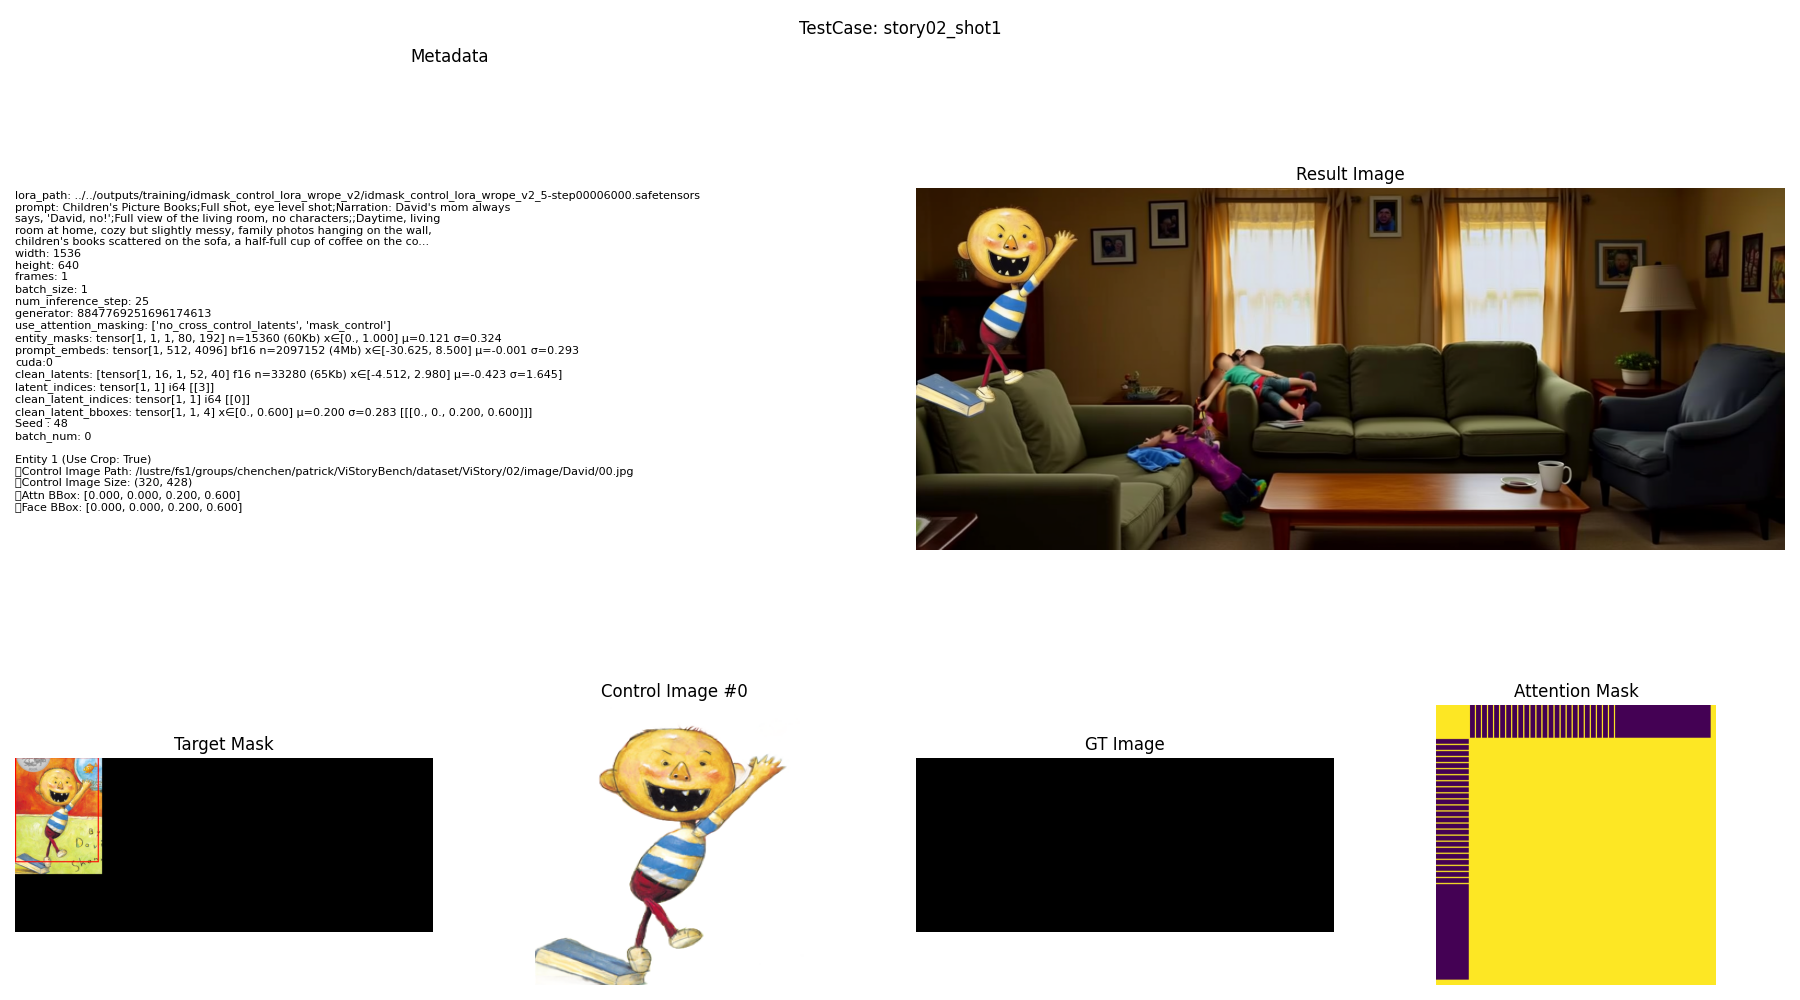

In [19]:
panel_id = '[PANEL-1]'
layout = joint_layout[panel_id]

shot_num = min(start_shot_num + int(panel_id.replace('[PANEL-', '').replace(']', ''))-1, end_shot_num)
panel_layout, width, height = get_panel_layout(layout, page_w, page_h)
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = story_shot['type'] + ";" + prompt
panel_layout = {0: {'bbox': [0.0, 0.0, 0.2, 0.6], 'body': []}}
characters_shot = {'David' : {'images': ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/02/image/David/00.jpg']}}

result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=320, seed=seed, 
    debug_name=f"story{story_num}_shot{shot_num}"
)
debug_imgs[0]


=== Story 02 - Shot 1 ===
Prompt: Children's Picture Books;Full shot, eye level shot;Narration: David's mom always says, 'David, no!';Full view of the living room, no characters;;Daytime, living room at home, cozy but slightly messy, family photos hanging on the wall, children's books scattered on the sofa, a half-full cup of coffee on the coffee table, soft natural light filtering through the curtains;


  0%|          | 0/25 [00:00<?, ?it/s]


=== Story 02 - Shot 2 ===
Prompt: Children's Picture Books;Medium shot, low-angle shot;One day, David stood on a stool, trying to reach his mom's candy box. Is this okay?;David stands on the stool, reaching for the candy box, his expression focused, leaning slightly forward;David is A lively Caucasian boy with blond hair and blue eyes, about five or six years old, always wearing a mischievous smile. He is dressed in a simple T-shirt and shorts, often wearing small sneakers, sometimes covered in mud or water stains, looking a bit messy but full of energy.;Daytime, kitchen, tidy cabinets with various utensils and spice bottles, a candy box placed on the central island, sunlight streaming through the window onto the floor;


  0%|          | 0/25 [00:00<?, ?it/s]

/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/frame_pack/hunyuan_video_packed.py:794: UserWarning: You are using Attention Mask, but sageattn does not support attention masking. Moving to normal SDPA
  warnings.warn(f"You are using Attention Mask, but {attn_mode} does not support attention masking. Moving to normal SDPA")
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/utils/viz_utils.py:190: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/utils/viz_utils.py:150: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.savefig(buf, format='png')



=== Story 02 - Shot 3 ===
Prompt: Children's Picture Books;Medium long shot, eye level shot;David walked into the room covered in mud, getting dirt all over the floor. Oh no! David, no! Take off your shoes and put on slippers!;David stands in the entryway, mud around his feet, his mom beside him with a helpless expression, pointing at the shoe rack;David is A lively Caucasian boy with blond hair and blue eyes, about five or six years old, always wearing a mischievous smile. He is dressed in a simple T-shirt and shorts, often wearing small sneakers, sometimes covered in mud or water stains, looking a bit messy but full of energy.;David's Mom is A young Caucasian mother with blond hair and blue eyes, in her early thirties, with a gentle face but sometimes a hint of helplessness. She wears comfortable home clothes, usually a loose blouse and casual pants, her hair simply tied into a ponytail, giving a warm and firm impression.;Daytime, home entryway, mud scattered on the floor, coat hook

  0%|          | 0/25 [00:00<?, ?it/s]


=== Story 02 - Shot 4 ===
Prompt: Children's Picture Books;Medium close up, eye level shot;It's bath time. He's playing pirate and water is splashing everywhere. David, no! Turn off the faucet.;David plays in the bathtub, holding a toy boat, water splashing around, looking excited;David is A lively Caucasian boy with blond hair and blue eyes, about five or six years old, always wearing a mischievous smile. He is dressed in a simple T-shirt and shorts, often wearing small sneakers, sometimes covered in mud or water stains, looking a bit messy but full of energy.;Evening, bathroom, water stains on the floor, bathtub filled with water, towels hanging on the wall, soft yellow lighting;


  0%|          | 0/25 [00:00<?, ?it/s]


=== Story 02 - Shot 5 ===
Prompt: Children's Picture Books;Medium shot, high-angle shot;David, come back! Go to your room and put on clothes. You can't run around naked.;David runs naked down the hallway, his mom chasing after him, looking anxious;David is A lively Caucasian boy with blond hair and blue eyes, about five or six years old, always wearing a mischievous smile. He is dressed in a simple T-shirt and shorts, often wearing small sneakers, sometimes covered in mud or water stains, looking a bit messy but full of energy.;David's Mom is A young Caucasian mother with blond hair and blue eyes, in her early thirties, with a gentle face but sometimes a hint of helplessness. She wears comfortable home clothes, usually a loose blouse and casual pants, her hair simply tied into a ponytail, giving a warm and firm impression.;Evening, home hallway, paintings hanging on the wall, clean and tidy floor, soft lighting;


  0%|          | 0/25 [00:00<?, ?it/s]


=== Story 02 - Shot 6 ===
Prompt: Children's Picture Books;Medium close up, eye level shot;David! Don't be noisy!;David jumps on the bed, shouting loudly, looking happy;David is A lively Caucasian boy with blond hair and blue eyes, about five or six years old, always wearing a mischievous smile. He is dressed in a simple T-shirt and shorts, often wearing small sneakers, sometimes covered in mud or water stains, looking a bit messy but full of energy.;Night, David's bedroom, toys scattered on the bed, cartoon posters on the wall, warm light from a bedside lamp;


  0%|          | 0/25 [00:00<?, ?it/s]

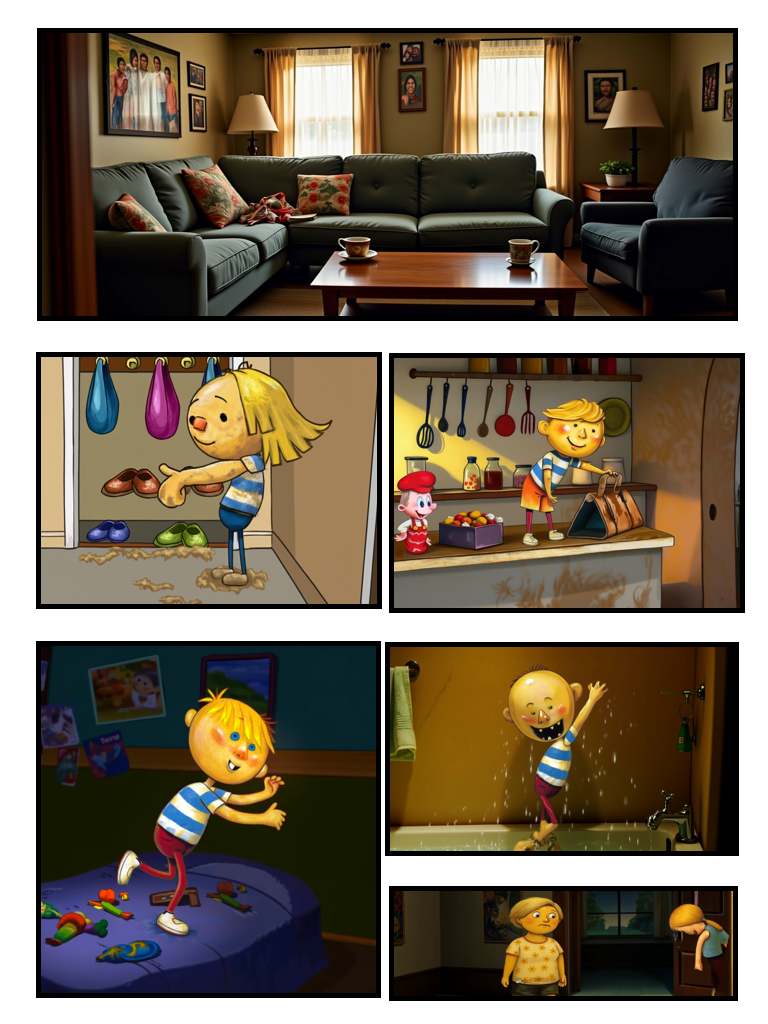

In [ ]:
results_dict = {}
for panel_id, layout in joint_layout.items():
    shot_num = min(start_shot_num + int(panel_id.replace('[PANEL-', '').replace(']', ''))-1, end_shot_num)
    panel_layout, width, height = get_panel_layout(layout, page_w, page_h)

    story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
    prompt = story_shot['type'] + ";" + prompt
    print(f"\n=== Story {story_num} - Shot {shot_num} ===")
    print(f"Prompt: {prompt}")

    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=320, seed=seed, 
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict[panel_id] = {
        'shot_num': shot_num, 
        'panel_layout': layout,
        'result_img': result_imgs[0],
        'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

final_img = draw_final_img(results_dict, page_w, page_h, key='result_img', panel_width=5)
final_img

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = Path("../../outputs/whisperer") / f"debug/en/{timestamp}"
out_dir.mkdir(parents=True, exist_ok=True)

main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053")
story_num = '02'
seed = 48
(out_dir / story_num).mkdir(parents=True, exist_ok=True)
(out_dir / f"{story_num}/debug").mkdir(parents=True, exist_ok=True)
(out_dir / f"{story_num}/full").mkdir(parents=True, exist_ok=True)

layouts = sorted(list(main_layout_path.glob(f"story_{story_num}*")))
for author_output_dir in layouts:
    start_shot_num, end_shot_num = author_output_dir.stem.split("_")[-2:]
    start_shot_num, end_shot_num = int(start_shot_num), int(end_shot_num)
    
    config_layout = json.loads((author_output_dir / "config.json").read_text())
    joint_layout = json.loads((author_output_dir / "pose_layout.json").read_text())
    page_w, page_h = config_layout['page_size']

    results_dict = {}
    for panel_id, layout in joint_layout.items():
        shot_num = min(start_shot_num + int(panel_id.replace('[PANEL-', '').replace(']', ''))-1, end_shot_num)
        panel_layout, width, height = get_panel_layout(layout, page_w, page_h)

        story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
        prompt = story_shot['type'] + ";" + prompt
        print(f"\n=== Story {story_num} - Shot {shot_num} ===")
        print(f"Prompt: {prompt}")

        result_imgs, debug_imgs, debug_mask = framepack_model(
            prompt, panel_layout, characters_shot, width, height,
            c_width_given=320, seed=seed, 
            debug_name=f"story{story_num}_shot{shot_num}"
        )

        results_dict[panel_id] = {
            'shot_num': shot_num, 
            'panel_layout': layout,
            'result_img': result_imgs[0],
            'debug_img': debug_imgs[0],
            'debug_mask': debug_mask,
        }

    final_img = draw_final_img(results_dict, page_w, page_h, key='result_img', panel_width=5)
    final_mask = draw_final_img(results_dict, page_w, page_h, key='debug_mask', panel_width=0)
    page_sub = convert_result_to_df_wpose(joint_layout, page_w, page_h)
    final_layout = annot_viz(Image.new("RGB", (page_w,page_h), (0,0,0)), page_sub, label_col='frame_id2')

    for panel_id, res in results_dict.items():
        shot_num = int(res['shot_num'])-1
        res['result_img'].save(out_dir / story_num / f"{shot_num}_0.png")
        res['debug_img'].save(out_dir / story_num / f"debug/{shot_num}_0.png")
    final_img.save(out_dir / f"{story_num}/full/{story_num}_{start_shot_num}_{end_shot_num}_final.png")
    final_mask.save(out_dir / f"{story_num}/full/{story_num}_{start_shot_num}_{end_shot_num}_final_mask.png")
    final_layout.save(out_dir / f"{story_num}/full/{story_num}_{start_shot_num}_{end_shot_num}_final_layout.png")

shutil.copy(
    "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/test_seg_4.ipynb", 
    out_dir / f"{story_num}/full/test_seg_4.ipynb"
)

In [ ]:
author_output_dir = Path("/groups/chenchen/patrick/comics/sample_layouts/Manga109/3ae58860/0033")
seed = np.random.randint(2**31) #1877106760
config_layout = json.loads((author_output_dir / "config.json").read_text())
joint_layout = json.loads((author_output_dir / "pose_layout.json").read_text())
page_w, page_h = config_layout['page_size']
joint_layout['[PANEL-1]']['images'] = ['/groups/chenchen/patrick/comics/sample_layouts/Manga109/3ae58860/0032/[PANEL-1]-[BODY-0].png']
joint_layout['[PANEL-2]']['images'] = ['/groups/chenchen/patrick/comics/sample_layouts/Manga109/3ae58860/0032/[PANEL-1]-[BODY-0].png']
joint_layout['[PANEL-3]']['images'] = ['/groups/chenchen/patrick/comics/sample_layouts/Manga109/3ae58860/0032/[PANEL-1]-[BODY-0].png']

results_dict = {}
for panel_id, layout in joint_layout.items():
    shot_num = int(panel_id.replace('[PANEL-', '').replace(']', ''))
    panel_layout, width, height = get_panel_layout(layout, page_w, page_h)
    
    prompt = "Japanese Black-and-white Manga; " + layout['prompt']
    characters_shot = {i: {'images': [x]} for i,x in enumerate(layout['images'])}
    print(f"\n=== Story {story_num} - Shot {shot_num} ===")
    print(f"Prompt: {prompt}")

    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt=prompt,
        panel_layout=panel_layout,
        characters_shot=characters_shot,
        width=width,
        height=height,
        c_width_given=320,
        crop_face_detect=True, use_face_detect=True, use_rembg=True,
        seed=seed
    )

    results_dict[panel_id] = {
        'shot_num': shot_num, 
        'panel_layout': layout,
        'result_img': result_imgs[0],
        'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

final_img = draw_final_img(results_dict, page_w, page_h, key='result_img', panel_width=5)
final_mask = draw_final_img(results_dict, page_w, page_h, key='debug_mask', panel_width=0)
final_img